In [1]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.6 MB/s eta 0:00:00


In [2]:
DATA_PATH = '/kaggle/input/dfdc20frames/'

In [3]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter, defaultdict
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
df = pd.read_csv(DATA_PATH + 'faces_metadata.csv')
df

,file_path,label
0,deepfake-detection/FAKE/FAKE/dfdc_train_part_9...,FAKE
1,deepfake-detection/FAKE/FAKE/dfdc_train_part_1...,FAKE
2,deepfake-detection/FAKE/FAKE/dfdc_train_part_8...,FAKE
3,deepfake-detection/FAKE/FAKE/dfdc_train_part_7...,FAKE
4,deepfake-detection/FAKE/FAKE/dfdc_train_part_4...,FAKE
...,...,...
5014,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5015,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5016,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL
5017,deepfake-detection/REAL/REAL/dfdc_train_part_1...,REAL


In [7]:
!ls /kaggle/input/

deepfakeseqdataset10dir  dfdc20frames  testdataset


In [8]:
def convert_path(path: str) -> str:
    for i in range(10):
        path = path.replace(f'{i:02}', str(i))
    return path


def process_file_paths(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((DATA_PATH + file_path, row['label']))

    return result


def get_video_info(video_path: str) -> Union[Tuple[int, float], Tuple[None, None]]:
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Не вдалося відкрити файл: {video_path}")
        return None, None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  
    cap.release()
    
    return frame_count, fps

In [9]:
video_stats = []
result = process_file_paths(df)

for video_path, label in result:
    frame_count, fps = get_video_info(video_path)
    if frame_count is not None and fps is not None:
        video_stats.append({
            'file_path': video_path,
            'label': label,
            'frames': frame_count,
            'fps': fps
        })

df = pd.DataFrame(video_stats)

stats_fps = df['fps'].describe()
stats_frames = df['frames'].describe()

print("FPS статистика:")
print(stats_fps)

print("\nКількість кадрів статистика:")
print(stats_frames)
#df = df[df['fps'] >= 28]

FPS статистика:
count    5019.000000
mean       29.478521
std         1.792622
min        12.474000
25%        29.969000
50%        29.970000
75%        29.970000
max        30.080000
Name: fps, dtype: float64

Кількість кадрів статистика:
count    5019.0
mean       20.0
std         0.0
min        20.0
25%        20.0
50%        20.0
75%        20.0
max        20.0
Name: frames, dtype: float64


In [10]:
files_to_remove_unique = set(['avjwhrqbwl_0', 'bpqrwvichd_0', 'cctrhqvein_0', 'eupisnxhsb_0', 'gerhijzwvq_0', 'katmliewya_0', 'onoowfeded_0',
                  'pydbvfkslp_0', 'qqisdvvgfi_0', 'sclvdumbkh_0', 'snphlfsrmr_0', 'spxqkpmopb_0', 'vugbaeziku_0', 'vvtcvjvkqx_0',
                   'xuoqfchsfj_0', 'zdkyyawcwe_0', 'mshechsves_0', 'ejwvqbeyef_0', 'pqbyjmgmrk_0', 'drmtykanjz_0', 'fktxniwzxe_0',
                   'iynuflmhau_0', 'kligyzlcuk_0', 'kifzxbsnku_0', 'kifzxbsnku_0', 'euarbrmuzs_0', 'fodhjwybqm_0', 'pbpgyiimwt_0',
                   'qmqfqyqmfx_0', 'thmwcolqan_0', 'xhwacojjdg_0', 'xkwjjjkcam_0', 'zktuaqrqqv_0', 'cioizeilvz_0', 'cotvlcroov_0',
                   'tuxbzsrszr_0', 'ynpqkrmuap_0', 'gomxkjifiu_0', 'ukrckkvaqi_0', 'vlcbaytswm_0', 'wmobvmntzu_0', 'ydqeopjemz_0',
                   'cxfbhgmuyu_0', 'hqqmtxvbjj_0', 'jaetnqgktl_0', 'yurtzoovou_0', 'hlcqjuwpsd_0', 'iarobzzslu_0', 'ailmasxkxb_0',
                   'bbwrqfawrj_0', 'cefzoeryat_0', 'egcuyhyvsm_0', 'eqgipviesf_0', 'fwekcrqdak_0', 'giqncczwue_0', 'hslupphtel_0',
                   'jmqmljznhv_0', 'lkbpavasad_0', 'osqruujwxd_0', 'pjibpowymk_0', 'ptchnzeeqc_0', 'sppyyoqaey_0', 'tohrqjyter_0',
                   'xzcexrifxq_0', 'aahncigwte_0', 'fszexmwczt_0', 'fszexmwczt_0', 'lkgrqfcrps_0', 'cdgrttukjn_0', 'eclxonfxph_0',
                   'eclxonfxph_0', 'gzbagbdubm_0', 'hhhvnhhqsc_0', 'junllgghcq_0', 'qyefejorlb_0'
                  ])
files_to_remove = list(files_to_remove_unique)
#df = df[~df['file_path'].apply(lambda x: any(file in x for file in files_to_remove))]
#df

In [11]:
def df_to_list(df: pd.DataFrame) -> List[Tuple[str, str]]:
    result: List[Tuple[str, str]] = []

    for _, row in df.iterrows():
        file_name = row['file_path']

        file_path = file_name

        result.append((file_path, row['label']))

    return result


result = df_to_list(df)
#result

In [12]:
groups = defaultdict(list)
for file_path, label in result:
    base_name = os.path.basename(file_path).split('_')[0]
    groups[base_name].append((file_path, label))

single_element_groups = [group for group in groups.values() if len(group) == 1]

#single_element_groups


In [13]:
train_files = [item for group in single_element_groups for item in group]

In [14]:
#train_files

In [15]:
df = pd.DataFrame(train_files, columns=['video_path', 'label'])
#real_videos = df[df['label'] == 'REAL']
#fake_videos = df[df['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#df = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)

train_data = df[~df['video_path'].str.contains('dfdc_train_part_8|dfdc_train_part_7')]
val_data = df[df['video_path'].str.contains('dfdc_train_part_8')]
test_data = df[df['video_path'].str.contains('dfdc_train_part_7')]

In [16]:
for i in range(11):
    subset_df = df[df['video_path'].str.contains(f'dfdc_train_part_{i}')]
    label_distribution = subset_df['label'].value_counts()
    print(i)
    print(label_distribution)

0
label
FAKE    143
REAL     68
Name: count, dtype: int64
1
label
FAKE    628
REAL    371
Name: count, dtype: int64
2
label
REAL    203
FAKE    157
Name: count, dtype: int64
3
label
REAL    199
FAKE    165
Name: count, dtype: int64
4
label
FAKE    158
REAL    154
Name: count, dtype: int64
5
label
REAL    310
FAKE    240
Name: count, dtype: int64
6
label
REAL    390
FAKE    380
Name: count, dtype: int64
7
label
REAL    306
FAKE    267
Name: count, dtype: int64
8
label
REAL    254
FAKE    214
Name: count, dtype: int64
9
label
REAL    258
FAKE    154
Name: count, dtype: int64
10
label
FAKE    429
REAL    278
Name: count, dtype: int64


In [17]:
#train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=17)

print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 3978
Val set size: 468
Test set size: 573


In [18]:
test_data

,video_path,label
3,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
8,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
12,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
20,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
21,/kaggle/input/dfdc20frames/deepfake-detection/...,FAKE
...,...,...
3795,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3796,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3797,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL
3798,/kaggle/input/dfdc20frames/deepfake-detection/...,REAL


In [19]:
#real_videos = train_data[train_data['label'] == 'REAL']
#fake_videos = train_data[train_data['label'] == 'FAKE']

#min_samples = min(len(real_videos), len(fake_videos))

#real_balanced = real_videos.sample(n=min_samples, random_state=42)
#fake_balanced = fake_videos.sample(n=min_samples, random_state=42)

#train_data = pd.concat([real_balanced, fake_balanced]).sample(frac=1, random_state=17)
#train_data

<Axes: >

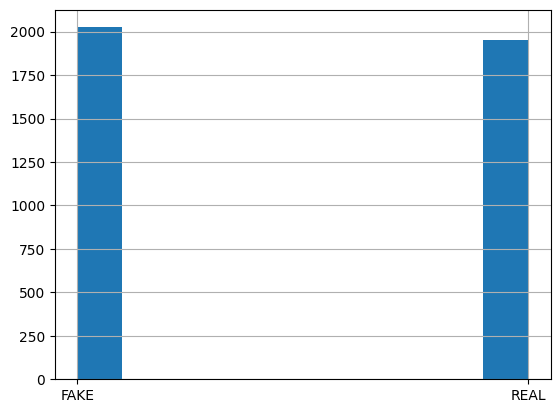

In [20]:
train_data['label'].hist()

<Axes: >

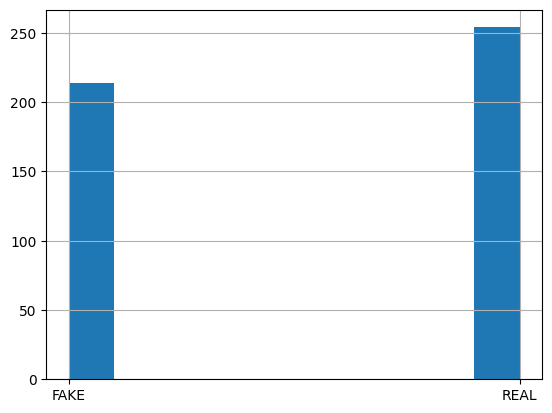

In [21]:
val_data['label'].hist()

<Axes: >

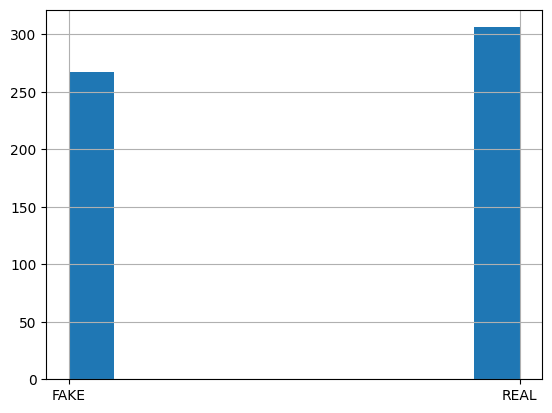

In [22]:
test_data['label'].hist()

In [23]:
print("Train set size:", len(train_data))
print("Val set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 3978
Val set size: 468
Test set size: 573


In [24]:
train_data.to_csv("train_dataset.csv", index=False)
val_data.to_csv("val_dataset.csv", index=False)
test_data.to_csv("test_dataset.csv", index=False)

In [25]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result: Dict[str, str] = {}

    for _, row in df.iterrows():
        file_path = row['video_path']
        label = row['label']

        result[file_path] = {'label': label}

    with open(output_json, 'w') as json_file:
        json.dump(result, json_file, indent=4)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('val_dataset.csv', 'output_balenced_val.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [26]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")

Label: FAKE, Count: 2025
Label: REAL, Count: 1953


In [27]:
from torchvision import transforms


class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, n_frames: int, df_path: str, device, cache_folder: str, image_size=(224, 224), transform=None):

        self.n_frames = n_frames
        self.videos = []
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.image_size = image_size
        
        self.transform = transform
        
        self.detector = MTCNN(device=device, post_process=False)

        with open(df_path) as f:
            videos = json.load(f)
            videos = [(video, metadata) for (video, metadata) in videos.items()]
            self.videos += videos

    def __getitem__(self, n):
        video, metadata = self.videos[n]
        video_id = os.path.splitext(os.path.basename(video))[0]
        cap = cv2.VideoCapture(video)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Загальна кількість кадрів у відео
        start_frame = random.randint(0, max(0, total_frames - self.n_frames))  # Випадковий стартовий кадр

        # Перемотка до стартового кадру
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        frames = []

        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize = (self.image_size[0], self.image_size[1])
            frame = cv2.resize(frame, resize)
            frame = torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
            frames.append(frame)

        cap.release()

        frames = torch.stack(frames).to(self.device)
        
        if self.transform:
            frames = self.transform(frames)

        label = 0.0
        if metadata['label'] == 'FAKE':
            label = 1.0

        return frames, torch.FloatTensor([label]).to(self.device)


    def __len__(self):
        return len(self.videos)

    
class SameAugmentation:
    def __init__(self, augmentations):
        """
        Args:
            augmentations (callable): Трансформації, що застосовуються до всіх кадрів.
        """
        self.augmentations = augmentations

    def __call__(self, frames):
        # Ініціалізуємо однакове перетворення
        seed = torch.randint(0, 2**32, (1,)).item()

        # Застосовуємо однакові трансформації до всіх кадрів
        augmented_frames = []
        for frame in frames:
            torch.manual_seed(seed)  # Встановлюємо однаковий seed
            augmented_frames.append(self.augmentations(frame))
        
        return torch.stack(augmented_frames)

Label: tensor([1.], device='cuda:0')


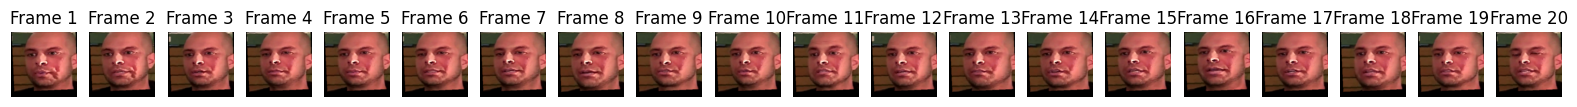

In [28]:
def test_train_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transfor = SameAugmentation(
        transforms.Compose([
            # Горизонтальне відображення
            transforms.RandomHorizontalFlip(p=0.5),
            # Легке афінне перетворення
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            # Легкий поворот
            transforms.RandomRotation(degrees=5, fill=0),
            # Розмиття для імітації відео низької якості
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            # Колірні зміни (яскравість, контраст)
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            # Перетворення в сірий для певного шуму
            transforms.RandomGrayscale(p=0.1),
        ])
    )
    
    dataset = VideoDataset(20, 'output_balenced_train.json', device, 'cache', (224, 224), transfor)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_train_data()

Label: tensor([1.], device='cuda:0')


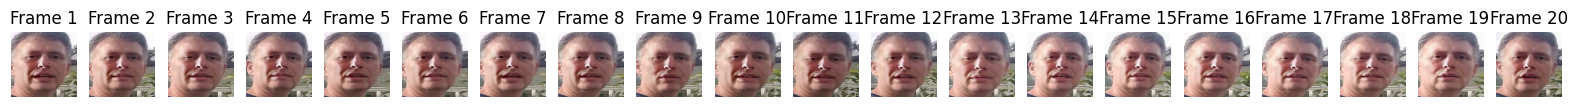

In [29]:
def test_test_data():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = VideoDataset(20, 'output_balenced_test.json', device, 'cache', (224, 224), None)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([20, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 20, figsize=(20, 10))

        for j in range(20):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break


test_test_data()

In [34]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    
    minposs = val_losses.index(min(val_losses)) 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [35]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [43]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, size: tuple[int], device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)
    
    early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.0001, path=f'early_stopping_{name}_lstm_checkpoint.pt')
    
    mean = [0.45, 0.45, 0.45]
    std = [0.225, 0.225, 0.225]
    
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    
    transfor_train = SameAugmentation(
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomRotation(degrees=5, fill=0),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=mean, std=std)
        ])
    )
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=mean, std=std),
        ])
    )

    train_dataset = VideoDataset(n_frames, path_train, device, 'cache', size, transfor_train)
    test_dataset = VideoDataset(n_frames, path_test, device, 'cache', size, transfor)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            
            loss = criterion(torch.sigmoid(output), labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())
                
                loss = criterion(output_probs, labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')
        val_auc = roc_auc_score(all_val_labels, test_probs)
        print(f'Validation AUC: {val_auc}')
        
        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
        )
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Validation AUC: {val_auc}')

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np


class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 6, 3],
            groups=32,
            width_per_group=4
        )
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)
        self.fc = nn.Identity()


class SelfAttention(nn.Module):
    def __init__(self, lstm_hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.key = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.value = nn.Linear(lstm_hidden_dim, lstm_hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_scores = torch.bmm(query, key.transpose(1, 2)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        attention_weights = self.dropout(attention_weights)

        attended_values = torch.bmm(attention_weights, value)
        return attended_values


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class ResNet3DClassifier(nn.Module):
    def __init__(self, dropout, freeze=False):
        super(ResNet3DClassifier, self).__init__()
        self.cnn3d = models.video.r3d_18(pretrained=True)
        
        if freeze:
            for param in self.cnn3d.parameters():
                param.requires_grad = False
                
        in_features = self.cnn3d.fc.in_features
        
        self.cnn3d.fc = nn.Sequential(
            nn.Linear(in_features, in_features // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features // 2, 1),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        return self.cnn3d(x)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 174MB/s]


Using 2 GPU!
Training ResNet3DClassifier model:
Hyperparameters {'dropout': 0.4, 'freeze': False, 'n_frames': 20, 'batch_size': 8, 'lr': 0.001, 'num_epochs': 40, 'gamma': 0.1, 'milestones': [16, 32]}
Start time: 2025-03-01 10:27:20.665622, using device: cuda


Epoch 1/40 - Train loss: 0.6832, Train accuracy: 0.5505
Validation loss: 0.6549, Validation accuracy: 0.6453, Time: 689.53s
Validation AUC: 0.690613731694753
Validation loss decreased (inf --> 0.654925).  Saving model ...


Epoch 2/40 - Train loss: 0.6477, Train accuracy: 0.6234
Validation loss: 0.6454, Validation accuracy: 0.6325, Time: 697.46s
Validation AUC: 0.7308852748546619
Validation loss decreased (0.654925 --> 0.645368).  Saving model ...


Epoch 3/40 - Train loss: 0.6123, Train accuracy: 0.6647
Validation loss: 0.5921, Validation accuracy: 0.7009, Time: 697.40s
Validation AUC: 0.7460261976598721
Validation loss decreased (0.645368 --> 0.592139).  Saving model ...


Epoch 4/40 - Train loss: 0.5836, Train accuracy: 0.6898
Validation loss: 0.6203, Validation accuracy: 0.6538, Time: 697.68s
Validation AUC: 0.7317315475752447
EarlyStopping counter: 1 out of 15


Epoch 5/40 - Train loss: 0.5551, Train accuracy: 0.7220
Validation loss: 0.5968, Validation accuracy: 0.6838, Time: 697.15s
Validation AUC: 0.7516189565089411
EarlyStopping counter: 2 out of 15


Epoch 6/40 - Train loss: 0.5210, Train accuracy: 0.7438
Validation loss: 0.5725, Validation accuracy: 0.6923, Time: 697.18s
Validation AUC: 0.7726653911251747
Validation loss decreased (0.592139 --> 0.572470).  Saving model ...


Epoch 7/40 - Train loss: 0.4956, Train accuracy: 0.7607
Validation loss: 0.5650, Validation accuracy: 0.6987, Time: 697.31s
Validation AUC: 0.7775406578850541
Validation loss decreased (0.572470 --> 0.564959).  Saving model ...


Epoch 8/40 - Train loss: 0.4874, Train accuracy: 0.7707
Validation loss: 0.5403, Validation accuracy: 0.7286, Time: 694.55s
Validation AUC: 0.8052652881006697
Validation loss decreased (0.564959 --> 0.540252).  Saving model ...


Epoch 9/40 - Train loss: 0.4649, Train accuracy: 0.7896
Validation loss: 0.5431, Validation accuracy: 0.7265, Time: 696.33s
Validation AUC: 0.8028552505703141
EarlyStopping counter: 1 out of 15


Epoch 10/40 - Train loss: 0.4609, Train accuracy: 0.7843
Validation loss: 0.4956, Validation accuracy: 0.7521, Time: 695.03s
Validation AUC: 0.8514055486054898
Validation loss decreased (0.540252 --> 0.495592).  Saving model ...


Epoch 11/40 - Train loss: 0.4409, Train accuracy: 0.7974
Validation loss: 0.4924, Validation accuracy: 0.7564, Time: 698.94s
Validation AUC: 0.8533372580763853
Validation loss decreased (0.495592 --> 0.492391).  Saving model ...


Epoch 12/40 - Train loss: 0.4447, Train accuracy: 0.7999
Validation loss: 0.4923, Validation accuracy: 0.7564, Time: 695.12s
Validation AUC: 0.8476157185959232
EarlyStopping counter: 1 out of 15


Epoch 13/40 - Train loss: 0.4280, Train accuracy: 0.8042
Validation loss: 0.4660, Validation accuracy: 0.7692, Time: 695.59s
Validation AUC: 0.8638604753845023
Validation loss decreased (0.492391 --> 0.466009).  Saving model ...


Epoch 14/40 - Train loss: 0.4099, Train accuracy: 0.8132
Validation loss: 0.5204, Validation accuracy: 0.7179, Time: 694.79s
Validation AUC: 0.8521046434616234
EarlyStopping counter: 1 out of 15


Epoch 15/40 - Train loss: 0.4129, Train accuracy: 0.8089
Validation loss: 0.4839, Validation accuracy: 0.7500, Time: 695.95s
Validation AUC: 0.8623702995069542
EarlyStopping counter: 2 out of 15


Epoch 16/40 - Train loss: 0.3890, Train accuracy: 0.8278
Validation loss: 0.5271, Validation accuracy: 0.7585, Time: 694.50s
Validation AUC: 0.880068437706969
EarlyStopping counter: 3 out of 15


Epoch 17/40 - Train loss: 0.3793, Train accuracy: 0.8384
Validation loss: 0.5073, Validation accuracy: 0.7564, Time: 696.27s
Validation AUC: 0.862591066303628
EarlyStopping counter: 4 out of 15


Epoch 18/40 - Train loss: 0.3951, Train accuracy: 0.8220
Validation loss: 0.5411, Validation accuracy: 0.7393, Time: 693.69s
Validation AUC: 0.8676135109279565
EarlyStopping counter: 5 out of 15


Epoch 19/40 - Train loss: 0.3751, Train accuracy: 0.8374
Validation loss: 0.4773, Validation accuracy: 0.7671, Time: 696.09s
Validation AUC: 0.8720840385606006
EarlyStopping counter: 6 out of 15


Epoch 20/40 - Train loss: 0.3812, Train accuracy: 0.8306
Validation loss: 0.4982, Validation accuracy: 0.7650, Time: 696.29s
Validation AUC: 0.8774192361468836
EarlyStopping counter: 7 out of 15


Epoch 21/40 - Train loss: 0.3813, Train accuracy: 0.8346
Validation loss: 0.4862, Validation accuracy: 0.7607, Time: 695.21s
Validation AUC: 0.8727831334167342
EarlyStopping counter: 8 out of 15


Epoch 22/40 - Train loss: 0.3906, Train accuracy: 0.8273
Validation loss: 0.5490, Validation accuracy: 0.7607, Time: 695.27s
Validation AUC: 0.8792037677533299
EarlyStopping counter: 9 out of 15


Epoch 23/40 - Train loss: 0.3784, Train accuracy: 0.8369
Validation loss: 0.4827, Validation accuracy: 0.7564, Time: 695.79s
Validation AUC: 0.8740157480314961
EarlyStopping counter: 10 out of 15


Epoch 24/40 - Train loss: 0.3848, Train accuracy: 0.8341
Validation loss: 0.5607, Validation accuracy: 0.7350, Time: 694.92s
Validation AUC: 0.8728015306497903
EarlyStopping counter: 11 out of 15


Epoch 25/40 - Train loss: 0.3604, Train accuracy: 0.8431
Validation loss: 0.4751, Validation accuracy: 0.7585, Time: 696.98s
Validation AUC: 0.877842372507175
EarlyStopping counter: 12 out of 15


Epoch 26/40 - Train loss: 0.3662, Train accuracy: 0.8404
Validation loss: 0.4555, Validation accuracy: 0.7821, Time: 695.76s
Validation AUC: 0.883674295385974
Validation loss decreased (0.466009 --> 0.455535).  Saving model ...


Epoch 27/40 - Train loss: 0.3766, Train accuracy: 0.8321
Validation loss: 0.5347, Validation accuracy: 0.7393, Time: 695.40s
Validation AUC: 0.8693980425344028
EarlyStopping counter: 1 out of 15


Epoch 28/40 - Train loss: 0.3709, Train accuracy: 0.8326
Validation loss: 0.4565, Validation accuracy: 0.7628, Time: 695.28s
Validation AUC: 0.887022591802193
EarlyStopping counter: 2 out of 15


Epoch 29/40 - Train loss: 0.3678, Train accuracy: 0.8454
Validation loss: 0.5129, Validation accuracy: 0.7671, Time: 695.13s
Validation AUC: 0.8729303112811834
EarlyStopping counter: 3 out of 15


Epoch 30/40 - Train loss: 0.3766, Train accuracy: 0.8363
Validation loss: 0.5796, Validation accuracy: 0.7415, Time: 695.63s
Validation AUC: 0.8709802045772316
EarlyStopping counter: 4 out of 15


Epoch 31/40 - Train loss: 0.3719, Train accuracy: 0.8451
Validation loss: 0.4949, Validation accuracy: 0.7585, Time: 697.22s
Validation AUC: 0.8721300316432408
EarlyStopping counter: 5 out of 15


Epoch 32/40 - Train loss: 0.3682, Train accuracy: 0.8351
Validation loss: 0.5734, Validation accuracy: 0.7479, Time: 697.66s
Validation AUC: 0.8847229376701743
EarlyStopping counter: 6 out of 15


Epoch 33/40 - Train loss: 0.3746, Train accuracy: 0.8326
Validation loss: 0.5411, Validation accuracy: 0.7479, Time: 698.93s
Validation AUC: 0.8777871808080066
EarlyStopping counter: 7 out of 15


Epoch 34/40 - Train loss: 0.3607, Train accuracy: 0.8429
Validation loss: 0.6371, Validation accuracy: 0.7137, Time: 698.36s
Validation AUC: 0.8791301788211054
EarlyStopping counter: 8 out of 15


Epoch 35/40 - Train loss: 0.3601, Train accuracy: 0.8477
Validation loss: 0.5386, Validation accuracy: 0.7415, Time: 696.44s
Validation AUC: 0.8831407756273456
EarlyStopping counter: 9 out of 15


Epoch 36/40 - Train loss: 0.3677, Train accuracy: 0.8446
Validation loss: 0.4743, Validation accuracy: 0.7585, Time: 697.84s
Validation AUC: 0.8831407756273457
EarlyStopping counter: 10 out of 15


Epoch 37/40 - Train loss: 0.3812, Train accuracy: 0.8358
Validation loss: 0.4724, Validation accuracy: 0.7628, Time: 696.93s
Validation AUC: 0.8754323349768194
EarlyStopping counter: 11 out of 15


Epoch 38/40 - Train loss: 0.3731, Train accuracy: 0.8358
Validation loss: 0.4891, Validation accuracy: 0.7628, Time: 700.57s
Validation AUC: 0.8680366472882479
EarlyStopping counter: 12 out of 15


Epoch 39/40 - Train loss: 0.3641, Train accuracy: 0.8517
Validation loss: 0.4929, Validation accuracy: 0.7585, Time: 700.28s
Validation AUC: 0.877106483184929
EarlyStopping counter: 13 out of 15


Epoch 40/40 - Train loss: 0.3748, Train accuracy: 0.8381
Validation loss: 0.6520, Validation accuracy: 0.7393, Time: 699.13s
Validation AUC: 0.8820001471778646
EarlyStopping counter: 14 out of 15
Training completed in: 7:44:31.818916


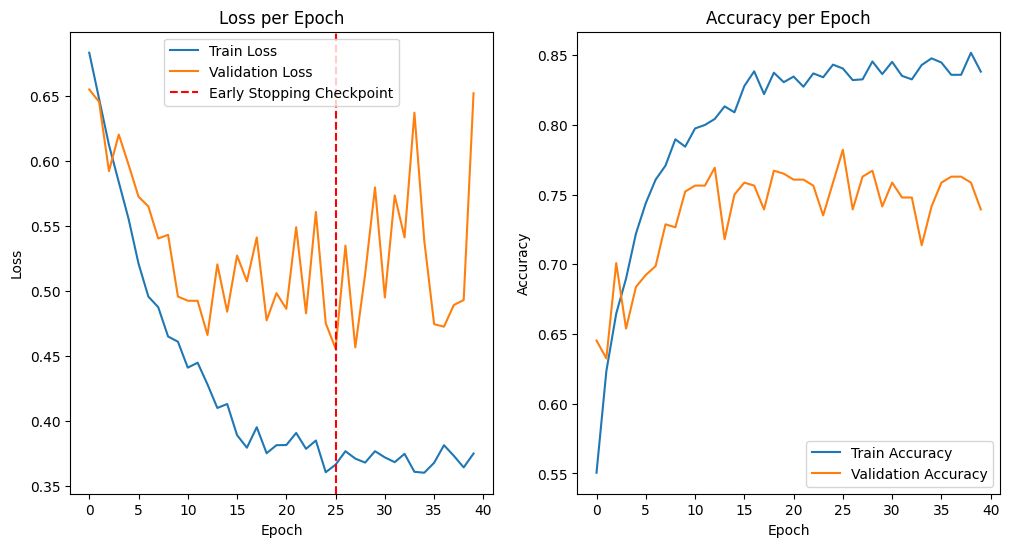

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84      1953
         1.0       0.85      0.83      0.84      2025

    accuracy                           0.84      3978
   macro avg       0.84      0.84      0.84      3978
weighted avg       0.84      0.84      0.84      3978



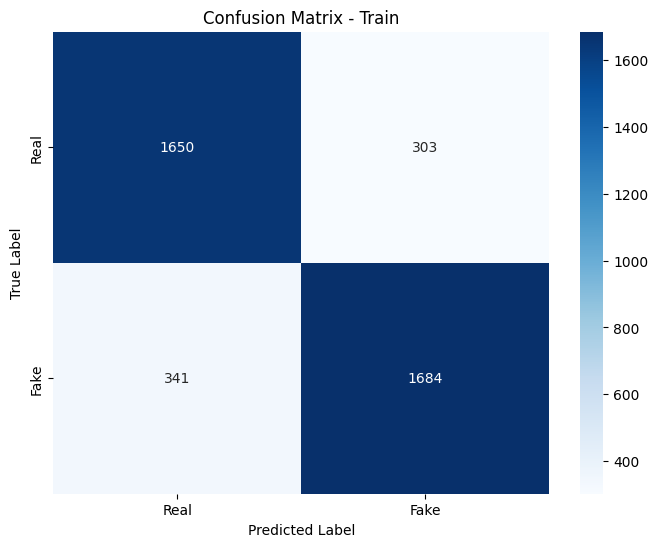

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.56      0.70       254
         1.0       0.65      0.95      0.77       214

    accuracy                           0.74       468
   macro avg       0.79      0.76      0.73       468
weighted avg       0.80      0.74      0.73       468



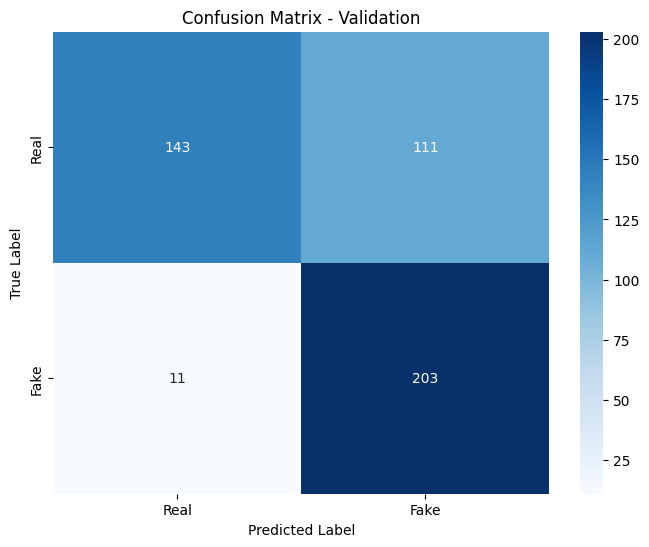

Validation AUC: 0.8820001471778646


In [47]:
hyperparameters_1: dict[str: Union[int, float, list]] = {
    'dropout': 0.4,
    'freeze': False,
    'n_frames': 20,
    'batch_size': 8,
    'lr': 0.001,
    'num_epochs': 40,
    'gamma': 0.1,
    'milestones': [16, 32]
}

models_to_train = [
    (ResNet3DClassifier, 'ResNet3DClassifier', (112, 112), hyperparameters_1)
]

for model_type, name, size, hyperparameters in models_to_train:
    model = model_type(
        dropout=hyperparameters['dropout'],
        freeze=hyperparameters['freeze']
    )

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPU!")
        model = nn.DataParallel(model)
    
    print(f'Training {name} model:')
    print('Hyperparameters', hyperparameters)
    trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_val.json', size, device, name)

In [48]:
def test_model(model: nn.Module, data_path: str, n_frames: int, size: Tuple[int, int]):
    batch_size = 1
    epoch_v_loss = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.BCELoss()

    mean = [0.45, 0.45, 0.45]
    std = [0.225, 0.225, 0.225]
    
    transfor = SameAugmentation(
        transforms.Compose([
            transforms.Normalize(mean=mean, std=std),
        ])
    )

    test_dataset = VideoDataset(n_frames, data_path, device, 'cache', size, transfor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model.eval()
    torch.cuda.empty_cache()
    gc.collect()
    
    all_val_labels, all_val_preds = [], []
    test_probs = []
    with torch.no_grad():
        for video_data, labels in tqdm(test_loader, desc="Test", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            output = model(video_data)
            output_probs = torch.sigmoid(output)
            test_probs.extend(output_probs.cpu().numpy())

            loss = criterion(output_probs, labels)
            epoch_v_loss += loss.item()

            output = torch.sigmoid(output).round()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(output.cpu().numpy())

            torch.cuda.empty_cache()
            gc.collect()
        
    val_loss = epoch_v_loss / len(test_loader)
    val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)

    print(f'Test loss: {val_loss:.4f}, Test accuracy: {val_accuracy:.4f}')

    print("Test Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Test')
    val_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Test AUC: {val_auc}')

Test loss: 0.7755, Test accuracy: 0.6928
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.57      0.66       306
         1.0       0.63      0.84      0.72       267

    accuracy                           0.69       573
   macro avg       0.71      0.70      0.69       573
weighted avg       0.72      0.69      0.69       573



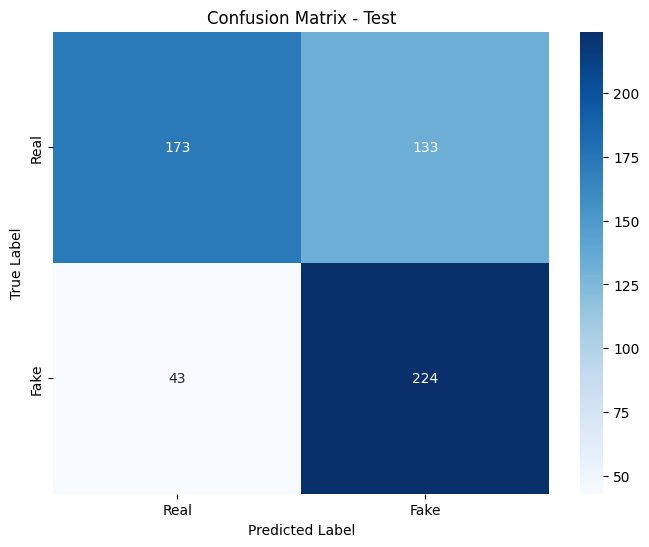

Test AUC: 0.812085383466745


5273

In [49]:
test_model(model, 'output_balenced_test.json', 20, (112, 112))
del model
torch.cuda.empty_cache()
gc.collect()

Test loss: 0.6552, Test accuracy: 0.7487
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       306
         1.0       0.75      0.69      0.72       267

    accuracy                           0.75       573
   macro avg       0.75      0.74      0.75       573
weighted avg       0.75      0.75      0.75       573



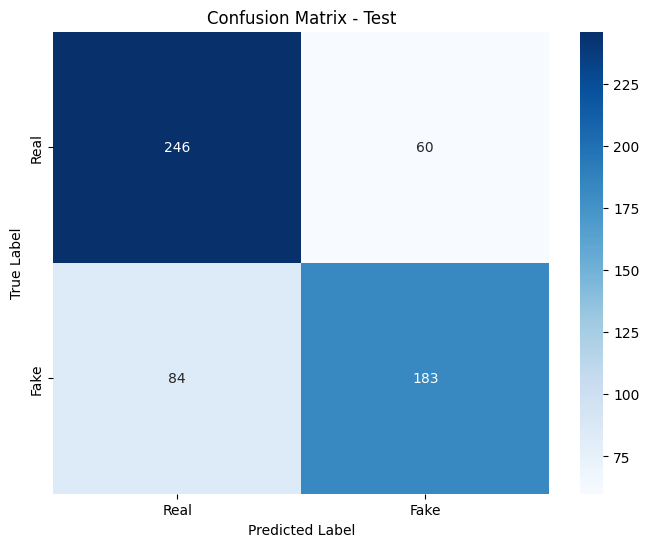

Test AUC: 0.815402315732785


In [50]:
model_path = '/kaggle/working/early_stopping_ResNet3DClassifier_lstm_checkpoint.pt'
    
model = ResNet3DClassifier(
    dropout=hyperparameters['dropout'],
    freeze=hyperparameters['freeze']
)
model = nn.DataParallel(model)
checkpoint = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint)

test_model(model, 'output_balenced_test.json', 20, (112, 112))